In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

Prepare the Dataset

In [ ]:
field_data = pd.read_csv("cleaned_field_data.csv")
field_data

,INSTNM,CONTROL,CIPDESC,CREDDESC,MD_EARN_WNE
0,Alabama A & M University,Public,"Computer and Information Sciences, General.",Bachelors Degree,54300
1,Alabama A & M University,Public,Teacher Education and Professional Development...,Bachelors Degree,25400
2,Alabama A & M University,Public,"Electrical, Electronics and Communications Eng...",Bachelors Degree,54500
3,Alabama A & M University,Public,Mechanical Engineering.,Bachelors Degree,45800
4,Alabama A & M University,Public,"Liberal Arts and Sciences, General Studies and...",Bachelors Degree,24000
...,...,...,...,...,...
19091,Inter American University of Puerto Rico - San...,"Private, nonprofit","Biology, General.",Bachelors Degree,12800
19092,Inter American University of Puerto Rico - San...,"Private, nonprofit","Psychology, General.",Bachelors Degree,12800
19093,Inter American University of Puerto Rico - San...,"Private, nonprofit",Criminal Justice and Corrections.,Bachelors Degree,17700
19094,Inter American University of Puerto Rico - San...,"Private, nonprofit","Registered Nursing, Nursing Administration, Nu...",Bachelors Degree,20900


In [ ]:
#Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

#Split into train and test set
X = field_data[["INSTNM", "CONTROL", "CIPDESC"]]
y = field_data[["MD_EARN_WNE"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

#One Hot Encode Categorical Variables 
enc = OneHotEncoder()
enc.fit(X)

enc_x_train = enc.transform(X_train).toarray()
enc_x_test = enc.transform(X_test).toarray()

In [ ]:
model = RandomForestRegressor(n_estimators=10, random_state = 0)
random_forest = model.fit(enc_x_train, y_train)

y_pred = random_forest.predict(enc_x_test)

print("MAE:" , metrics.mean_absolute_error(y_test, y_pred))
print("MSE:", metrics.mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
MAE: 5296.926701570681
MSE: 63369021.15183246
RMSE: 7960.466139104698


In [ ]:
y_pred

array([53260., 58540., 29300., ..., 28550., 26670., 31800.])

In [ ]:
y_test

,MD_EARN_WNE
4591,53800
14291,63800
14532,21700
1145,25500
3690,28700
...,...
9259,26800
18551,33900
11729,39100
3520,31100


In [ ]:
#Let's test the model using an arbitrary example to see how well it performs
test_pred = np.array([["Alabama A & M University", "Public", "Computer and Information Sciences, General."]])
test_df = pd.DataFrame(data = test_pred,  index = ["0"],  columns = ["INSTNM","CONTROL", "CIPDESC"]) 
print(test_df)

enc_test = enc.transform(test_df).toarray()
y_pred = random_forest.predict(enc_test)
print("Predicted median earnings:", y_pred)

                     INSTNM CONTROL  \
0  Alabama A & M University  Public   

                                       CIPDESC  
0  Computer and Information Sciences, General.  
Predicted median earnings: [52790.]


In [ ]:
#Find the actual median earnings for a student who goes to Alabama A&M University majoring in CS
filtered_df = field_data.loc[(field_data['INSTNM'] == "Alabama A & M University") & (field_data['CONTROL'] == "Public") & (field_data['CIPDESC'] == "Computer and Information Sciences, General.")]
filtered_df

,INSTNM,CONTROL,CIPDESC,CREDDESC,MD_EARN_WNE
0,Alabama A & M University,Public,"Computer and Information Sciences, General.",Bachelors Degree,54300


In [ ]:
print("Percent difference (%) between actual and predicted median earnings:", (y_pred.item() - filtered_df["MD_EARN_WNE"].item())/filtered_df["MD_EARN_WNE"].item() * -100)

Percent difference (%) between actual and predicted median earnings: 2.7808471454880292


Model seemed to do a decent job of predicting the median earnings, but let's bin the data and see if we can increase the accuracy

In [ ]:
#Print out max and min median earnings
max = field_data["MD_EARN_WNE"].max()
min = field_data["MD_EARN_WNE"].min()
print("Max:", max)
print("Min:", min)

Max: 153300
Min: 4400


In [ ]:
#Print out other data statistics
std1 = field_data["MD_EARN_WNE"].std()
print('std: ' + str(std1))
quantile1 = field_data["MD_EARN_WNE"].quantile(q=0.25)
print('25%: ' + str(quantile1))
quantile2 = field_data["MD_EARN_WNE"].quantile(q=0.50)
print('50%: ' + str(quantile2))
quantile3 = field_data["MD_EARN_WNE"].quantile(q=0.75)
print('75%: ' + str(quantile3))

std: 14494.643439216601
25%: 28200.0
50%: 34200.0
75%: 45200.0


In [ ]:
#Lets try bins of $10,000 from $0 USD to $160,000 USD
field_data["Salary Range"] = pd.cut(field_data["MD_EARN_WNE"], bins = np.arange(0, 170000, 10000))
field_data["Salary Range"]

0        (50000, 60000]
1        (20000, 30000]
2        (50000, 60000]
3        (40000, 50000]
4        (20000, 30000]
              ...      
19091    (10000, 20000]
19092    (10000, 20000]
19093    (10000, 20000]
19094    (20000, 30000]
19095    (20000, 30000]
Name: Salary Range, Length: 19096, dtype: category
Categories (16, interval[int64]): [(0, 10000] < (10000, 20000] < (20000, 30000] < (30000, 40000] ... (120000, 130000] < (130000, 140000] < (140000, 150000] < (150000, 160000]]

In [ ]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

#Split into train and test set
X = field_data[["INSTNM", "CONTROL","CIPDESC"]]
y = field_data[["Salary Range"]]

from sklearn.preprocessing import LabelEncoder

#Label Encode Target Column of Salary Bins

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

#One Hot Encode Categorical Features
enc = OneHotEncoder()
enc.fit(X)

enc_x_train = enc.transform(X_train).toarray()
enc_x_test = enc.transform(X_test).toarray()

/opt/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [ ]:
model = RandomForestClassifier(n_estimators = 30, random_state = 0)
random_forest = model.fit(enc_x_train, y_train)

y_pred = random_forest.predict(enc_x_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average = 'weighted'))

[[  0   0   0   1   0   1   0   0   0   0   0   0]
 [  0   9  86  28   5   0   1   0   0   0   0   0]
 [  0  11 724 372  11   1   0   0   0   0   0   0]
 [  0   3 320 835 107  17   7   0   0   0   0   0]
 [  0   0  19 257 170  44  13   1   0   0   0   0]
 [  0   0   4  42  86 182  66   1   0   0   0   0]
 [  0   0   3  14  31 126 116   5   0   0   0   0]
 [  0   0   0   3   5  17  45   3   0   0   0   0]
 [  0   0   0   4   1   8   4   1   0   0   0   0]
 [  0   0   1   0   0   4   2   0   0   0   0   0]
 [  0   0   0   0   0   1   1   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.39      0.07      0.12       129
           2       0.63      0.65      0.64      1119
           3       0.54      0.65      0.59      1289
           4       0.41      0.34      0.37       504
           5       0.45      0.48      0.47       381
        

In [ ]:
predicted_salary = le.inverse_transform(y_pred)
predicted_salary[:10]

array([Interval(30000, 40000, closed='right'),
       Interval(30000, 40000, closed='right'),
       Interval(30000, 40000, closed='right'),
       Interval(50000, 60000, closed='right'),
       Interval(40000, 50000, closed='right'),
       Interval(20000, 30000, closed='right'),
       Interval(30000, 40000, closed='right'),
       Interval(20000, 30000, closed='right'),
       Interval(30000, 40000, closed='right'),
       Interval(30000, 40000, closed='right')], dtype=object)

In [ ]:
actual_salary = le.inverse_transform(y_test)
actual_salary[:10]

array([Interval(30000, 40000, closed='right'),
       Interval(30000, 40000, closed='right'),
       Interval(30000, 40000, closed='right'),
       Interval(50000, 60000, closed='right'),
       Interval(40000, 50000, closed='right'),
       Interval(30000, 40000, closed='right'),
       Interval(30000, 40000, closed='right'),
       Interval(20000, 30000, closed='right'),
       Interval(30000, 40000, closed='right'),
       Interval(30000, 40000, closed='right')], dtype=object)

In [ ]:
error = y_pred - y_test
print("Average error: ", np.average(error))
unique, counts = np.unique(error, return_counts=True)
np.asarray((unique, counts)).T

Average error:  -0.10209424083769633


array([[  -7,    1],
       [  -6,    2],
       [  -5,    5],
       [  -4,   11],
       [  -3,   33],
       [  -2,  116],
       [  -1,  846],
       [   0, 2039],
       [   1,  680],
       [   2,   70],
       [   3,   15],
       [   5,    2]])

In [ ]:
estimator = random_forest.estimators_[0]

from sklearn import tree
text_representation = tree.export_text(estimator)
print(text_representation)

|--- feature_1729 <= 0.50
|   |--- feature_1836 <= 0.50
|   |   |--- feature_1705 <= 0.50
|   |   |   |--- feature_1783 <= 0.50
|   |   |   |   |--- feature_1923 <= 0.50
|   |   |   |   |   |--- feature_1708 <= 0.50
|   |   |   |   |   |   |--- feature_1850 <= 0.50
|   |   |   |   |   |   |   |--- feature_1721 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_1712 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_1727 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_1851 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 392
|   |   |   |   |   |   |   |   |   |   |--- feature_1851 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |   |   |   |   |   |--- feature_1727 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_1425 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 39
|   |   |   |   |   |   |   |   |   |   |--- feature_1425 >  0.50

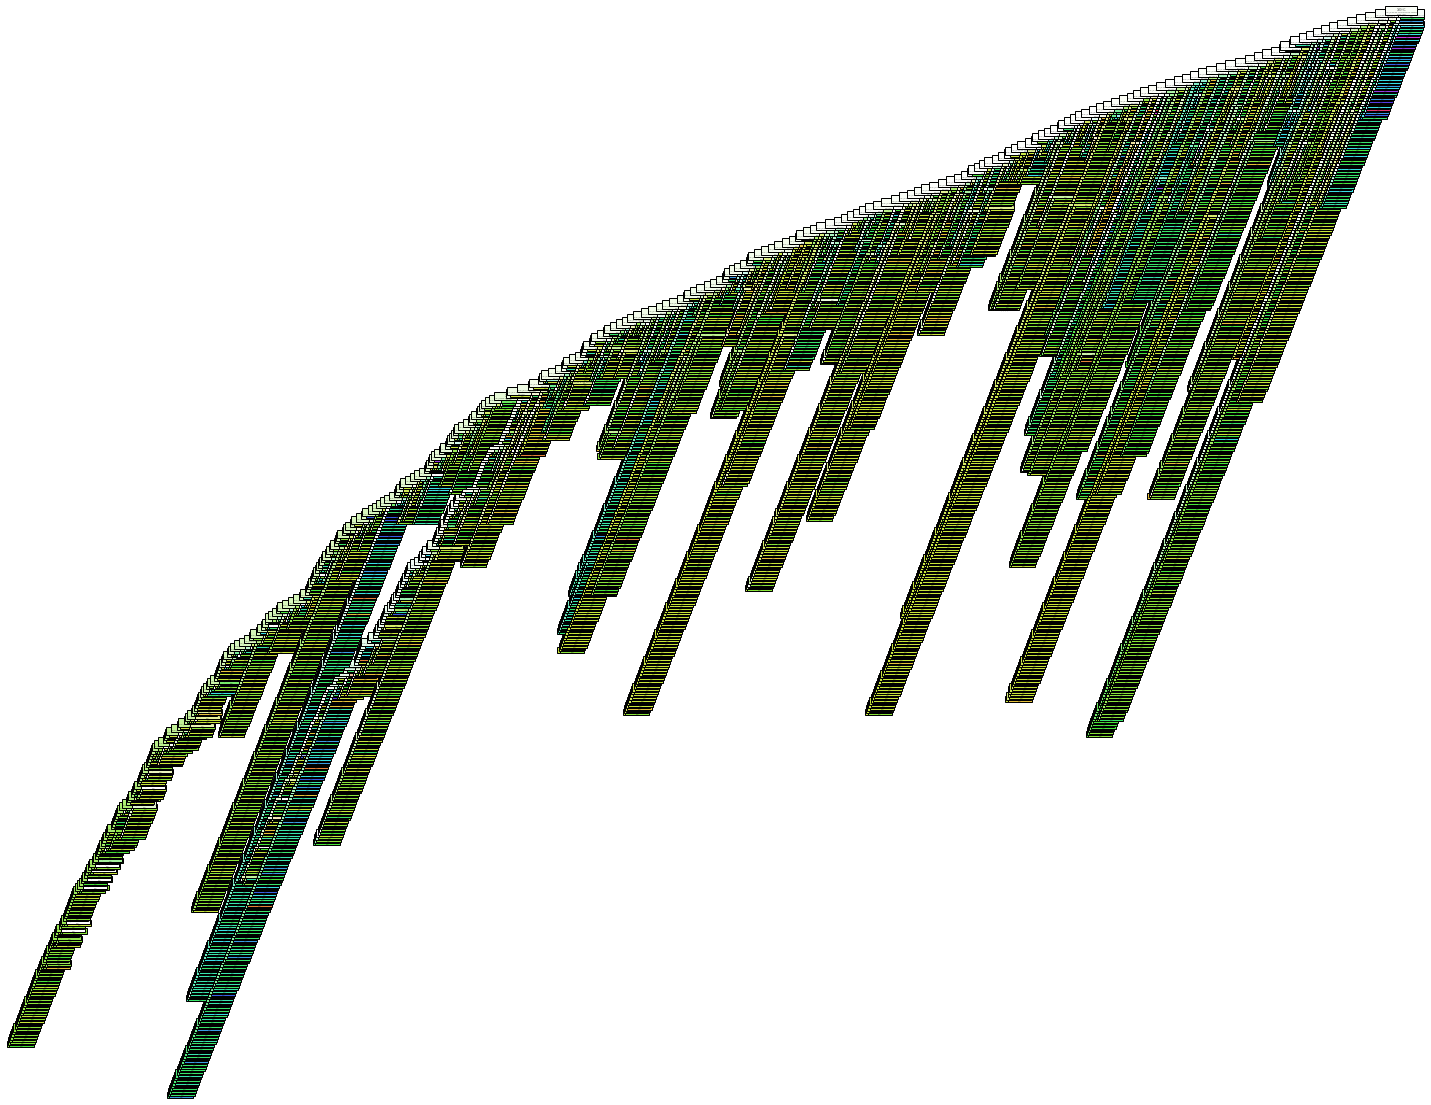

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(estimator, filled=True)
fig.savefig("decistion_tree2.svg")